In [10]:
import torch
import torchaudio
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nnAudio.features.vqt import VQT

In [21]:
def extract_vqt_transformer(sample_rate):
    """
    创建并返回VQT变换对象。
    
    VQT（Variable-Q Transform）是CQT的扩展，具有可变的Q因子，
    允许在不同频率范围内使用不同的时频分辨率权衡。
    VQT特别适合分析具有复杂频谱结构的音频信号。
    
    Args:
        sample_rate (int): 音频采样率，决定了频谱分析的频率范围
        n_bins (int): VQT频率bins的数量，默认80
        gamma (float): Q因子的缩放参数，控制频率分辨率，默认20.05
    
    Returns:
        nnAudio.features.vqt.VQT: 初始化完成的VQT对象
    """
    vqt_transformer = VQT(
        sr=sample_rate,
        bins_per_octave=12,
        n_bins=80,
        hop_length=512,
        fmin=20,
        gamma=30.0,
        window='hann',
        trainable=False,
    )

    return vqt_transformer


In [22]:
def save_vqt_to_csv(vqt_features, output_csv):
    """
    将VQT特征保存为CSV文件
    :param vqt_features: VQT特征矩阵
    :param output_csv: CSV文件路径
    """
    df = pd.DataFrame(vqt_features)
    df.to_csv(output_csv, index=False, header=False)
    print(f"VQT特征已保存至 {output_csv}")


In [23]:
def plot_cqt_features(cqt_data, sr, output_image=None):
    """
    可视化VQT特征
    :param vqt_data: VQT特征矩阵
    :param sr: 采样率
    :param output_image: 如果提供路径，则保存图片
    """
    plt.figure(figsize=(12, 8))

    vqt_db = librosa.amplitude_to_db(vqt_data, ref=np.max) 
    librosa.display.specshow(vqt_db, sr=sr, hop_length=512, fmin=20.0, x_axis='time', y_axis='cqt_hz', cmap='turbo')
    plt.title("VQT Features")
    plt.xlabel("Time(s)")
    plt.ylabel("VQT(Hz)")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

    if output_image:
        plt.savefig(output_image)
        print(f"VQT特征图已保存至 {output_image}")
    else:
        plt.show()

Low pass filter created, time used = 0.0000 seconds
num_octave =  7
No early downsampling is required, downsample_factor =  1
Early downsampling filter created,                         time used = 0.0000 seconds
VQT特征图已保存至 vqt_features.png


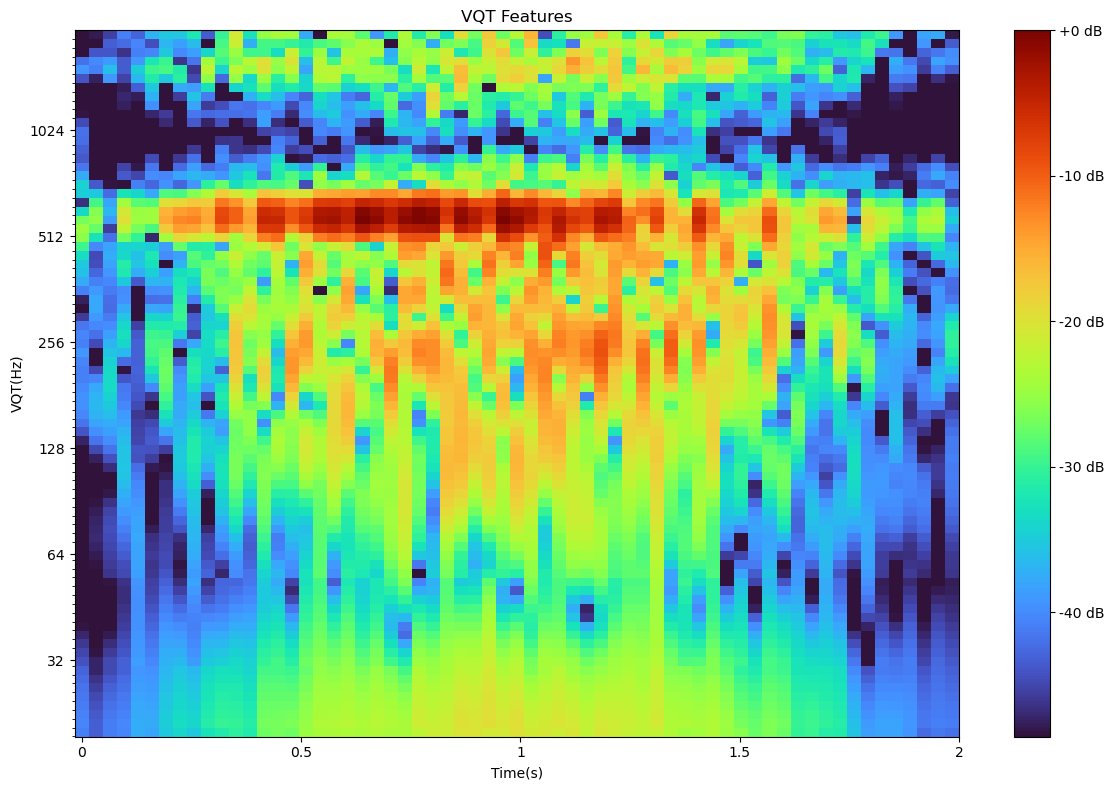

In [ ]:
# 音频文件路径
audio_file = r'E:\数据集\ShipEar\data_preprocessing\3_Frame_Windows_2s_50%\6__10_07_13_marDeCangas_Entra_18.wav'

waveform, original_sr = torchaudio.load(audio_file)

# 重采样
target_sr = 16000
if original_sr != target_sr:
    resampler = torchaudio.transforms.Resample(original_sr, target_sr)
    waveform = resampler(waveform)

vqt_transformer = extract_vqt_transformer(target_sr)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
waveform = waveform.to(device)
vqt_transformer = vqt_transformer.to(device)
vqt = vqt_transformer(waveform)

vqt_data = vqt.detach().cpu().numpy()[0]

# 保存VQT特征到CSV
save_cqt_to_csv(vqt_data, 'vqt_features.csv')

# 可视化VQT特征
plot_cqt_features(vqt_data, target_sr, 'vqt_features.png')
